## Prepare imports

In [27]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch_geometric.data import Batch
from models.vae import BaseModel as VAE
from models.encoder import BaseModel as Encoder


from layers.ect import EctLayer, EctConfig
from layers.directions import generate_directions
from load_configs import load_config
from datasets import load_datamodule

DEVICE = "cuda:0"
ECT_PLOT_CONFIG = {"cmap":"bone","vmin":-0.5,"vmax":1.5}
PC_PLOT_CONFIG = {"s":10,"c":'.5'}



encoder_config = load_config("./configs/config_encoder_mnist.yaml")
vae_config = load_config("./configs/config_vae_mnist.yaml")


## Load Models and Data

In [28]:

dm = load_datamodule(encoder_config.data)

vae = VAE.load_from_checkpoint("./trained_models/vae_mnist.ckpt").cuda()
encoder = Encoder.load_from_checkpoint("./trained_models/ectencoder_mnist.ckpt").cuda()


In [29]:
data_list = []
for idx in range(10):
    data_list.append(dm.test_ds[dm.test_ds.y==idx][1])

batch = Batch.from_data_list(data_list).to(DEVICE)

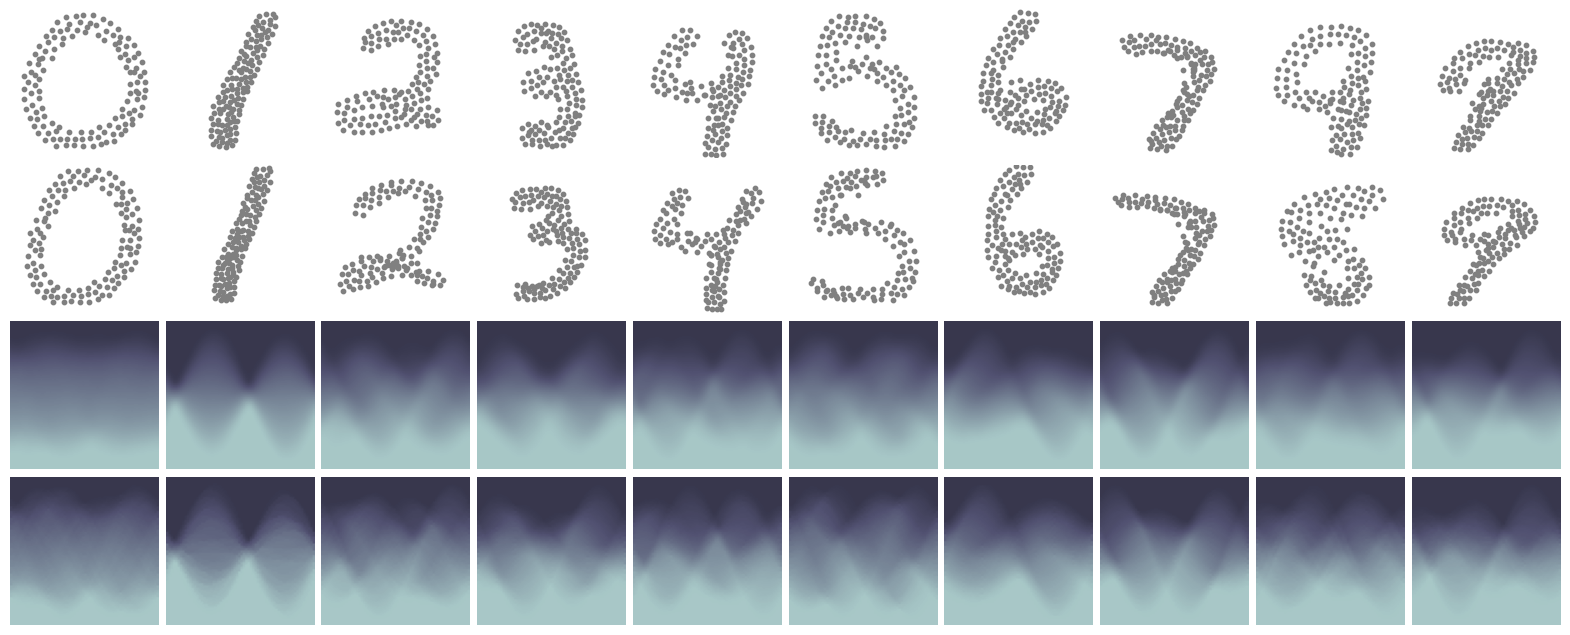

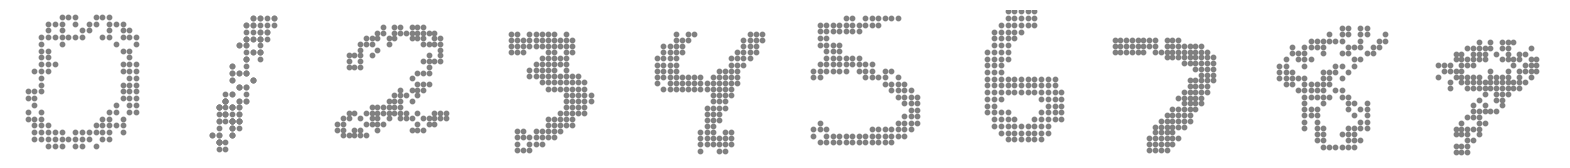

In [31]:
def rotate(p, origin=(0, 0), degrees=0):
    angle = np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)



ect = encoder.layer(batch,batch.batch).unsqueeze(1)

# decoded = torch.zeros_like(ect)

with torch.no_grad():
    decoded, _,_,_ = vae(ect*2-1)
    decoded = (decoded.squeeze()+1)/2
    recon_vae_batch = encoder.model.forward(decoded)
    recon_batch = encoder.model.forward(ect.squeeze())


fig, axes = plt.subplots(
    nrows=4, ncols=10, figsize=(20,8)
)
fig.subplots_adjust(wspace=0.05,hspace=0.05)
    


for orig_pts, recon_pts, recon_vae_pts,orig_img, recon_img,axis in zip(batch.x.view(-1,128,2),recon_batch,recon_vae_batch,ect,decoded,axes.T):
    # print(recon_pts_x.shape)
    recon_pts = recon_pts.view(-1,2).cpu().detach().squeeze().numpy()
    orig_pts = orig_pts.view(-1,2).cpu().detach().squeeze().numpy()
    recon_vae_pts = recon_vae_pts.view(-1,2).cpu().detach().squeeze().numpy()
    orig_pts = rotate(orig_pts, degrees=-90)
    recon_pts = rotate(recon_pts, degrees=-90)
    recon_vae_pts = rotate(recon_vae_pts, degrees=-90)

    ax = axis[0]
    ax.scatter(recon_vae_pts[:,0],recon_vae_pts[:,1],**PC_PLOT_CONFIG)
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    ax.set_aspect(1)
    ax.axis("off")


    ax = axis[1]
    ax.scatter(recon_pts[:,0],recon_pts[:,1],**PC_PLOT_CONFIG)
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    ax.set_aspect(1)
    ax.axis("off")

    ax = axis[2]
    ax.imshow(recon_img.cpu().detach().squeeze().numpy(),**ECT_PLOT_CONFIG)
    ax.axis("off")

    ax = axis[3]
    ax.imshow(orig_img.cpu().detach().squeeze().numpy(),**ECT_PLOT_CONFIG)
    ax.axis("off")    

plt.savefig("./figures/img/mnist/reconstructed_mnist.svg",transparent=True)   



fig, axes = plt.subplots(
    nrows=1, ncols=10, figsize=(20,8)
)
fig.subplots_adjust(wspace=0.05,hspace=0.05)


for orig_pts, recon_pts, recon_vae_pts,orig_img, recon_img,axis in zip(batch.x.view(-1,128,2),recon_batch,recon_vae_batch,ect,decoded,axes.T):
    # print(recon_pts_x.shape)
    recon_pts = recon_pts.view(-1,2).cpu().detach().squeeze().numpy()
    orig_pts = orig_pts.view(-1,2).cpu().detach().squeeze().numpy()
    recon_vae_pts = recon_vae_pts.view(-1,2).cpu().detach().squeeze().numpy()
    orig_pts = rotate(orig_pts, degrees=-90)
    recon_pts = rotate(recon_pts, degrees=-90)
    recon_vae_pts = rotate(recon_vae_pts, degrees=-90)


    ax = axis
    ax.scatter(orig_pts[:,0],orig_pts[:,1],**PC_PLOT_CONFIG)
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    ax.set_aspect(1)
    ax.axis("off")

plt.savefig("./figures/img/mnist/mnist_base_pointclouds.svg",transparent=True)   


## Sample from VAE and reconstruct points 

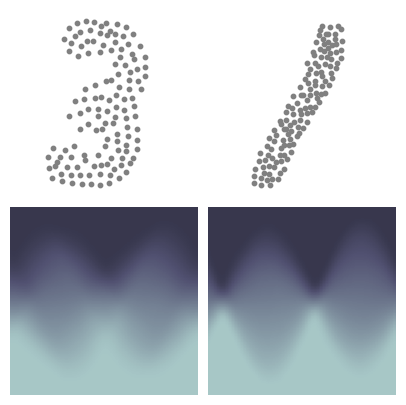

In [34]:
samples = vae.model.sample(64, "cuda:0")
samples = (samples + 1) / 2
recon_samples = encoder.model.forward(samples)


n_images = 2

fig, axes = plt.subplots(
    nrows=2, ncols=n_images, figsize=(5,5)
)
fig.subplots_adjust(wspace=0.05,hspace=0.05)


for samples_pts,sample,ax in zip(recon_samples,samples,axes.T):
    samples_pts = samples_pts.view(-1,2).cpu().detach().squeeze().numpy()
    samples_pts = rotate(samples_pts, degrees=-90)
    ax[0].scatter(samples_pts[:,0],samples_pts[:,1],**PC_PLOT_CONFIG)
    ax[0].set_xlim([-1,1])
    ax[0].set_ylim([-1,1])
    ax[0].set_aspect(1)
    ax[0].axis("off")
    ax[1].imshow(sample.squeeze().cpu().detach().numpy(),**ECT_PLOT_CONFIG)
    ax[1].axis("off")

plt.savefig("./figures/img/mnist/generated_samples.svg",transparent=True) 

# Latent space of the ECT

In [35]:
# Get all validation samples.
import pandas as pd 

ys = []
zs = []
mfld = []
with torch.no_grad():
    for batch in dm.val_dataloader():
        batch.cuda()
        ect_val = 2*vae.layer(batch,batch.batch) -1 
        mu, log_var = vae.model.encode(ect_val.unsqueeze(1))
        z = vae.model.reparameterize(mu, log_var)
        recon_ect = (vae.model.decode(z)+1)/2
        ys.append(batch.y)
        zs.append(mu)
        mfld.append(batch.x.view(-1,128,2))

    ys = torch.hstack(ys)
    zs = torch.vstack(zs)
    mfld = torch.vstack(mfld).cpu().numpy()


zs.shape

torch.Size([6000, 64])

In [38]:
import seaborn as sns 

df = pd.DataFrame(zs.to(dtype=torch.float16).cpu().detach().numpy())
df["label"] = ys.cpu().to(dtype=int)

In [39]:

# sns.pairplot(df,x_vars=[60,61,62],y_vars=[0,1,2],hue='label')

In [40]:
import umap 
from sklearn.preprocessing import StandardScaler

# scaled_latent_vectors = StandardScaler().fit_transform(df[[i for i in range(64)]])


C:\Users\ernst\AppData\Local\Temp\ipykernel_27968\2947746447.py:13: UserWarning:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.



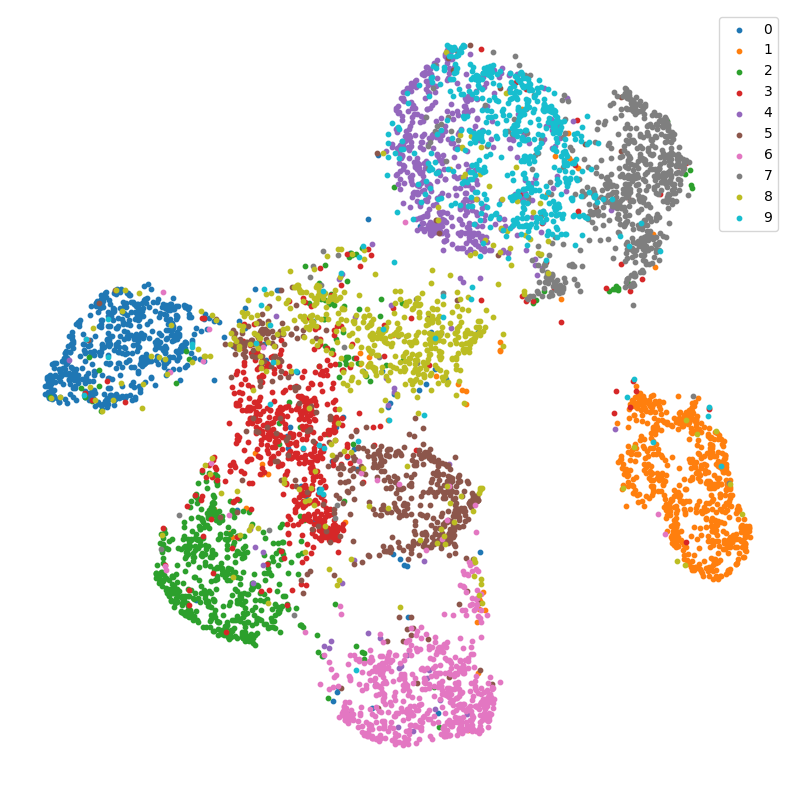

In [43]:

reducer = umap.UMAP(
        n_neighbors=25,
        min_dist=0.1,
        n_components=2,
        metric="euclidean"
    )
embedding = reducer.fit_transform(df[[i for i in range(64)]])

fig, ax = plt.subplots(figsize=(10,10))

for label in range(10):
    idx = df["label"] == label
    ax.scatter(
        embedding[idx, 0],
        embedding[idx, 1],
        s=10,
        c=sns.color_palette()[label],label=str(label))
ax.legend()
ax.axis("off")
fig.savefig("./figures/img/mnist/latent_visualization.svg",transparent=True)

In [44]:

reducer = umap.UMAP(
        n_neighbors=25,
        min_dist=0.1,
        n_components=3,
        metric="euclidean"
    )
embedding = reducer.fit_transform(df[[i for i in range(64)]])



In [45]:
# import pyvista as pv
# pv.set_jupyter_backend("trame")

# pl = pv.Plotter(shape=(1, 1), window_size=[800, 800],border=False,polygon_smoothing=True)
# pl.subplot(0,0)
# for label in range(10):
#     idx = df["label"] == label
#     actor = pl.add_points(
#         embedding[idx],
#         style="points",
#         emissive=False,
#         show_scalar_bar=False,
#         render_points_as_spheres=True,
#         color=sns.color_palette()[label],label=str(label),
#         point_size=5,
#         ambient=.3, 
#         # diffuse=1.5, 
#         # specular=0.8,
#         # specular_power=20, 
#         smooth_shading=True
#     )


# pl.background_color = "w"
# pl.link_views()
# pl.camera_position = "yz"
# pos = pl.camera.position
# pl.camera.position = (pos[0],pos[1],pos[2]+3)
# pl.camera.azimuth = -45
# pl.camera.elevation = 10

# # create a top down light
# light = pv.Light(position=(0, 0, 3), positional=True,
#                 cone_angle=50, exponent=20, intensity=.2)
# pl.add_light(light)
# pl.camera.zoom(1.3)
# # pl.screenshot("./figures/img/topological/generated_samples.png",transparent_background=True,scale=2)
# pl.show()

In [46]:
mfld.shape

(6000, 128, 2)

In [47]:
import io
import base64
import pickle

from dash import Dash, dcc, html, Input, Output, no_update, callback
import plotly.graph_objects as go

from PIL import Image

from sklearn.manifold import TSNE
import numpy as np


def embeddable_image(data):
    data = data.reshape(-1,2)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.axis("off")
    ax.scatter(data[:,0],data[:,1])
    buffer = io.BytesIO()
    fig.savefig(buffer, format='jpeg', dpi=100)
    plt.close()
    for_encoding = buffer.getvalue()

    ret =  'data:image/jpeg;base64,' + base64.b64encode(for_encoding).decode()
    return ret

# Color for each digit
color_map = {
    0: "#E52B50",
    1: "#9F2B68",
    2: "#3B7A57",
    3: "#3DDC84",
    4: "#FFBF00",
    5: "#915C83",
    6: "#008000",
    7: "#7FFFD4",
    8: "#E9D66B",
    9: "#007FFF",
}
colors = [color_map[label] for label in df["label"]]

fig = go.Figure(data=[go.Scatter3d(
    x=embedding[:, 0],
    y=embedding[:, 1],
    z=embedding[:, 2],
    mode='markers',
    marker=dict(
        size=2,
        color=colors,
    )
)])

fig.update_traces(
    hoverinfo="none",
    hovertemplate=None,
)

app = Dash(__name__)

app.layout = html.Div(
    className="container",
    children=[
        dcc.Graph(id="graph-5", figure=fig, clear_on_unhover=True),
        dcc.Tooltip(id="graph-tooltip-5", direction='bottom'),
    ],
)

@callback(
    Output("graph-tooltip-5", "show"),
    Output("graph-tooltip-5", "bbox"),
    Output("graph-tooltip-5", "children"),
    Input("graph-5", "hoverData"),
)
def display_hover(hoverData):
    if hoverData is None:
        return False, no_update, no_update

    # demo only shows the first point, but other points may also be available
    hover_data = hoverData["points"][0]
    bbox = hover_data["bbox"]
    num = hover_data["pointNumber"]
    
    im_url = embeddable_image(mfld[num])
    children = [
        html.Div([
            html.Img(
                src=im_url,
                style={"width": "50px", 'display': 'block', 'margin': '0 auto'},
            ),
            html.P("MNIST Digit ", style={'font-weight': 'bold'})
        ])
    ]

    return True, bbox, children

app.run_server(mode='jupyterlab', port = 8091, dev_tools_ui=True, debug=True,
              dev_tools_hot_reload =True, threaded=True)